## Constituency dataset validation


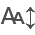

In [1]:
from policyengine_uk import Microsimulation
import pandas as pd
import h5py
from itables import init_notebook_mode
import itables.options as opt
from pathlib import Path
from policyengine.utils.huggingface import download
from policyengine_uk_data.storage import STORAGE_FOLDER

opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

REPO = Path(".").resolve().parent

weights_file_path = STORAGE_FOLDER / "parliamentary_constituency_weights.h5"
with h5py.File(weights_file_path, "r") as f:
        weights = f[str(2025)][...]

constituencies = pd.read_csv(STORAGE_FOLDER / "constituencies_2024.csv")

baseline = Microsimulation()
household_weights = baseline.calculate("household_weight", 2025).values

from policyengine_uk_data.datasets.frs.local_areas.constituencies.loss import create_constituency_target_matrix, create_national_target_matrix

constituency_target_matrix, constituency_actuals = create_constituency_target_matrix("enhanced_frs_2022_23", 2025, None)
national_target_matrix, national_actuals = create_national_target_matrix("enhanced_frs_2022_23", 2025, None)

constituency_wide = weights @ constituency_target_matrix
constituency_wide.index = constituencies.code.values
constituency_wide["name"] = constituencies.name.values

constituency_results = pd.melt(constituency_wide.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

constituency_actuals.index = constituencies.code.values
constituency_actuals["name"] = constituencies.name.values
constituency_actuals_long = pd.melt(constituency_actuals.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

constituency_target_validation = pd.merge(constituency_results, constituency_actuals_long, on=["index", "variable"], suffixes=("_target", "_actual"))
constituency_target_validation.drop("name_actual", axis=1, inplace=True)
constituency_target_validation.columns = ["index", "name", "metric", "estimate", "target"]

constituency_target_validation["error"] = constituency_target_validation["estimate"] - constituency_target_validation["target"]
constituency_target_validation["abs_error"] = constituency_target_validation["error"].abs()
constituency_target_validation["rel_abs_error"] = constituency_target_validation["abs_error"] / constituency_target_validation["target"]

### Calibration check
Looking at the sorted validation results by relative absolute error shows how well our calibrated weights perform against the actual target statistics across UK parliamentary constituencies under the new 2024 boundaries. The table reveals the accuracy of our estimates, from the closest matches to the largest discrepancies, where a lower relative error indicates better calibration performance.

In [2]:
constituency_target_validation.sort_values("rel_abs_error", ascending=False)

index                              name                    metric  \
247   E14001310          Kensington and Bayswater  hmrc/total_income/amount   
97    E14001160                Chelsea and Fulham  hmrc/total_income/amount   
109   E14001172  Cities of London and Westminster  hmrc/total_income/amount   
202   E14001265            Hampstead and Highgate  hmrc/total_income/amount   
382   E14001445                     Richmond Park  hmrc/total_income/amount   
...         ...                               ...                       ...   
1066  E14001479         Solihull West and Shirley   hmrc/total_income/count   
1442  E14001205          Dulwich and West Norwood                  age/0_10   
1026  E14001439    Reading West and Mid Berkshire   hmrc/total_income/count   
366   E14001429                             Poole  hmrc/total_income/amount   
758   E14001171                      Christchurch   hmrc/total_income/count   

          estimate        target         error     abs_error  rel_abs_error  
247   4.096908e+09  1.576401e+10 -1.166711e+10  1.166711e+10       0.740110  
97    3.928113e+09  1.218443e+10 -8.256316e+09  8.256316e+09       0.677612  
109   4.725083e+09  1.402316e+10 -9.298082e+09  9.298082e+09       0.663052  
202   4.186280e+09  1.019354e+10 -6.007261e+09  6.007261e+09       0.589320  
382   3.928054e+09  8.311778e+09 -4.383724e+09  4.383724e+09       0.527411  
...            ...           ...           ...           ...            ...  
1066  5.848713e+04  5.850595e+04 -1.882521e+01  1.882521e+01       0.000322  
1442  1.561473e+04  1.561229e+04  2.434325e+00  2.434325e+00       0.000156  
1026  5.633829e+04  5.633011e+04  8.179993e+00  8.179993e+00       0.000145  
366   2.759484e+09  2.759392e+09  9.241626e+04  9.241626e+04       0.000033  
758   5.075770e+04  5.075811e+04 -4.120690e-01  4.120690e-01       0.000008  

[6500 rows x 8 columns]

In [3]:
national_performance = household_weights @ national_target_matrix
national_target_validation = pd.DataFrame({"metric": national_performance.index, "estimate": national_performance.values})
national_target_validation["target"] = national_actuals.values

national_target_validation["error"] = national_target_validation["estimate"] - national_target_validation["target"]
national_target_validation["abs_error"] = national_target_validation["error"].abs()
national_target_validation["rel_abs_error"] = national_target_validation["abs_error"] / national_target_validation["target"]

The table below shows the relative absolute error for each calibration target at the **national level**, sorted from the closest matches to the largest discrepancies.

In [4]:
national_target_validation.sort_values("rel_abs_error")

metric      estimate  \
32                                     obr/tax_credits  5.616313e+09   
229  hmrc/private_pension_income_income_band_48_70_...  1.237713e+10   
97                                ons/london_age_30_39  1.583098e+06   
215  hmrc/private_pension_income_income_band_47_50_...  2.193850e+10   
122                             ons/scotland_age_10_19  5.999660e+05   
..                                                 ...           ...   
146  hmrc/private_pension_income_count_income_band_...  9.710027e+05   
152  hmrc/dividend_income_count_income_band_42_12_5...  1.196584e+05   
143  hmrc/state_pension_income_band_42_12_570.0_to_...  1.236036e+10   
144  hmrc/state_pension_count_income_band_42_12_570...  1.116327e+06   
149  hmrc/savings_interest_income_income_band_42_12...  1.592776e+08   

           target         error     abs_error  rel_abs_error  
32  -1.000000e+08  5.716313e+09  5.716313e+09     -57.163133  
229  1.236528e+10  1.184927e+07  1.184927e+07       0.000958  
97   1.585000e+06 -1.902044e+03  1.902044e+03       0.001200  
215  2.183503e+10  1.034687e+08  1.034687e+08       0.004739  
122  5.970000e+05  2.965971e+03  2.965971e+03       0.004968  
..            ...           ...           ...            ...  
146  1.738270e+05  7.971757e+05  7.971757e+05       4.586029  
152  2.021400e+04  9.944436e+04  9.944436e+04       4.919579  
143  1.819054e+09  1.054130e+10  1.054130e+10       5.794935  
144  1.492520e+05  9.670751e+05  9.670751e+05       6.479478  
149  1.901933e+07  1.402583e+08  1.402583e+08       7.374513  

[335 rows x 6 columns]